<a href="https://colab.research.google.com/github/uervitonsantos/Atividade_Analise_Bayeseana_Com_RSTAN/blob/main/trabalho_de_estatistivca_bayesiana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Atividade de analise inferencial Bayseana com RStan aplicado em um conjunto de dados de confiabilidade de motores

O dataset utilizado na analise pode ser obtido em: https://drive.google.com/file/d/1OF0tsCE1EZj7f5gNVjxuS_Dv-NwQo0Jf/view?usp=share_link

In [ ]:
!pip install rpy2==3.5.4

In [ ]:
%load_ext rpy2.ipython

In [44]:
%%R
# Realiza a instalação dos pacotes necessarios para a analise
if(!require(rstanarm))
install.packages("rstanarm")
if(!require(ggpubr))
install.packages("ggpubr")
if(!require(skimr))
devtools::install_github("ropensci/skimr")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [46]:
%%R
# Deixa as bibliotecas instaladas disponiveis para a analise
library(ggplot2)
library(dplyr)
library(bayesplot)
library(rstanarm)
library(ggpubr)
library(loo)
library(skimr)
theme_set(bayesplot::theme_default())

In [47]:
%%R
# Monta o dataset na variavel dados
dados <- read.csv("/content/drive/MyDrive/Colab Notebooks/DateSet/Motor_Bomba.csv", header = TRUE, sep = ";", dec = ",")

In [50]:
%%R
# Mostra os detalhes do dataset, como suas colunas, tipos de variaveis e valores
str(dados)

'data.frame':	363 obs. of  23 variables:
 $ ano                           : int  2016 2016 2016 2016 2016 2016 2016 2016 2016 2016 ...
 $ dia                           : int  2 3 4 5 6 7 8 9 10 11 ...
 $ falha                         : int  0 0 0 0 0 0 0 0 0 1 ...
 $ severidade_mc                 : int  0 0 0 0 0 0 0 0 0 10 ...
 $ temp_estator_fase_U           : int  38 38 38 38 38 38 38 38 38 38 ...
 $ temp._estator_fase_v          : int  40 40 40 40 40 40 40 40 40 40 ...
 $ temp_estator_fase_wa          : int  37 37 37 37 37 37 37 36 36 36 ...
 $ temp_estator_fase_wb          : int  39 39 39 39 39 39 39 39 39 39 ...
 $ vibracoo_bomba_la             : int  0 0 0 0 0 0 0 0 0 0 ...
 $ vazao_bomba                   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ corrente                      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ pressao_desc.                 : int  0 0 0 0 0 0 0 0 0 0 ...
 $ pressao_suc                   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ posicao_fcv                   : int  0 0 0 0 0 0 0 

In [51]:
%%R
# O pacote skimr é usado para ajudar a analizar dos dados contidos no dataset
skim(dados)

── Data Summary ────────────────────────
                           Values
Name                       dados 
Number of rows             363   
Number of columns          23    
_______________________          
Column type frequency:           
  numeric                  23    
________________________         
Group variables            None  

── Variable type: numeric ──────────────────────────────────────────────────────
   skim_variable                  n_missing complete_rate      mean      sd   p0
 1 ano                                    0             1 2016        0     2016
 2 dia                                    0             1  183      105.       2
 3 falha                                  0             1    0.0606   0.239    0
 4 severidade_mc                          0             1    3.14    13.6      0
 5 temp_estator_fase_U                    0             1   57.4     22.0     34
 6 temp._estator_fase_v                   0             1   59.8     22.7     35
 7 t

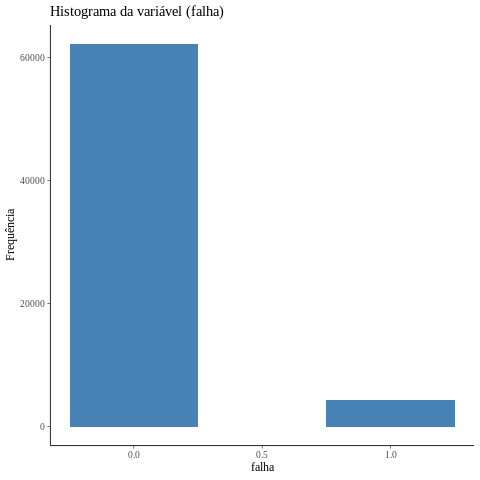

In [69]:
%%R
# No grafico abaixo podemos verificar uma super-inflação de zeros na variavel (falha)
ggplot(dados, aes(x = falha, y = dia)) +
geom_histogram(stat="identity", width=.5, fill = "steelblue") +
labs(title = "Histograma da variável (falha)", y = "Frequência")

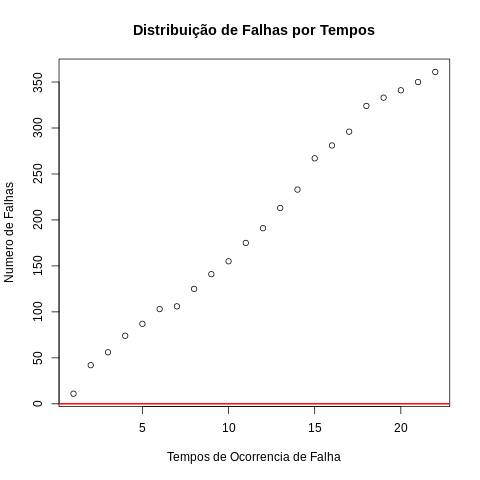

In [53]:
%%R
# Abaixo temos uma representação grafica previa da distribuição das falhas ocorridas nos dias correntes
plot(dados$dia[dados$falha > "0"], ylab="Numero de Falhas", xlab="Tempos de Ocorrencia de Falha", main = "Distribuição de Falhas por Tempos")
lines(density(dados$dia),
 lwd = 2,
 col = "red")

In [54]:
%%R
# O modelo utilizará a variavel (falha) como dependente e as seguntes variáveis independentes: dia, severidade_mc, 
# temp_estator_fase_U, temp_estator_fase_wa, temp_estator_fase_wb, vibracoo_bomba_la, corrente, pressao_desc., 
# pressao_suc, temp_externo_mancal_escora_lna, temp_interno_mancal_escora_lna, temp_mancal_la_bomba, temp_mancal_la_motor, 
# temp_mancal_lna_bomba, temp_mancal_lna_motor, temp_oleo_ulf. Para todas as variaves será usada uma priori de uma 
# distribuição normal com média (0) como desvios padrões de (2.5). A priori da constante α como uma normal centrada 
# em 0 e com um desvio padrão 5

stan_poisson <- stan_glm(falha ~ dia + severidade_mc 
                                                  + temp_estator_fase_U
                                                  + temp_estator_fase_wa
                                                  + temp_estator_fase_wb
                                                  + vibracoo_bomba_la
                                                  + corrente
                                                  + pressao_desc.
                                                  + pressao_suc
                                                  + temp_externo_mancal_escora_lna
                                                  + temp_interno_mancal_escora_lna
                                                  + temp_mancal_la_bomba
                                                  + temp_mancal_la_motor
                                                  + temp_mancal_lna_bomba
                                                  + temp_mancal_lna_motor
                                                  + temp_oleo_ulf ,
                      data = dados,  
                      family = poisson, 
                      prior = normal(0,2.5),
                      prior_intercept = normal(0,5),
                      chains = 4, 
                      cores = 1, 
                      seed = 123, 
                      refresh=0
                    )
summary(stan_poisson)


Model Info:
 function:     stan_glm
 family:       poisson [log]
 formula:      falha ~ dia + severidade_mc + temp_estator_fase_U + temp_estator_fase_wa + 
	   temp_estator_fase_wb + vibracoo_bomba_la + corrente + pressao_desc. + 
	   pressao_suc + temp_externo_mancal_escora_lna + temp_interno_mancal_escora_lna + 
	   temp_mancal_la_bomba + temp_mancal_la_motor + temp_mancal_lna_bomba + 
	   temp_mancal_lna_motor + temp_oleo_ulf
 algorithm:    sampling
 sample:       4000 (posterior sample size)
 priors:       see help('prior_summary')
 observations: 363
 predictors:   17

Estimates:
                                 mean   sd     10%    50%    90% 
(Intercept)                    -103.7  277.8 -570.0    2.8  155.1
dia                              -0.2    1.6   -2.4   -0.2    1.9
severidade_mc                     1.2    1.4   -1.2    1.7    2.5
temp_estator_fase_U               2.1    2.0   -0.4    2.1    4.6
temp_estator_fase_wa              0.3    2.8   -3.6    0.3    4.1
temp_estator

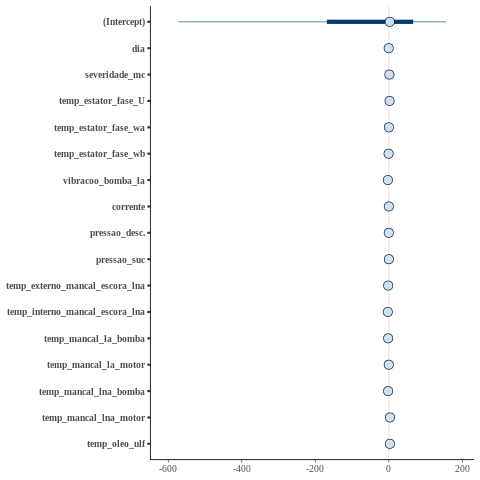

In [70]:
%%R
plot(stan_poisson)

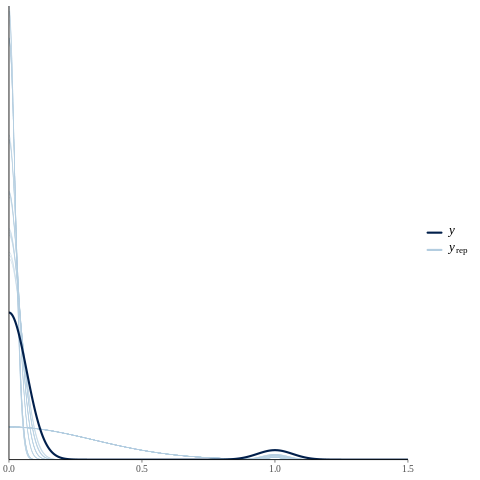

In [55]:
%%R
# Grafico da Posterior Preditive Check do modelo de Poisson
# É possivel verificar no grafico abaixo que a função de verossimilhança não se ajusta bem a variavel dependente do modelo
pp_check(stan_poisson, ndraws = 50) + xlim(0, 1.5)

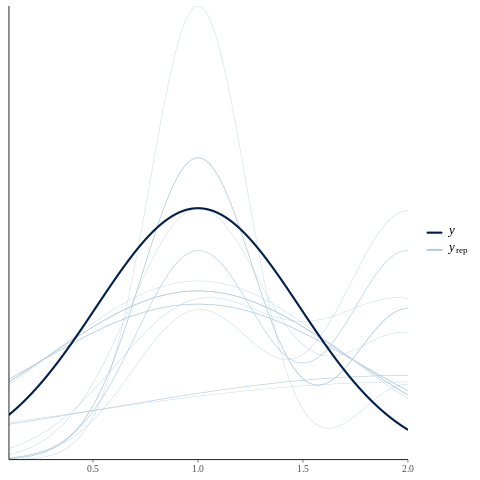

In [56]:
%%R
# Grafico da Posterior Preditive Check do modelo de Poisson. faixa entre 0.1 e 2
# É possivel verificar no grafico abaixo que a função de verossimilhança não se ajusta bem a variavel dependente do modelo
pp_check(stan_poisson, ndraws = 50) + xlim(0.1, 2)

In [57]:
%%R
# Abaixo é usada a função exp() para realizar a inverção do logarítmo de (y) para 
# interpretação dos coeficientes do modelo de distribuição de Poisson
coef <- exp(stan_poisson$coefficients)
coef

                   (Intercept)                            dia 
                   16.46603338                     0.81101887 
                 severidade_mc            temp_estator_fase_U 
                    5.56307495                     8.36566975 
          temp_estator_fase_wa           temp_estator_fase_wb 
                    1.36678938                     0.58907157 
             vibracoo_bomba_la                       corrente 
                    0.08750685                     1.18187994 
                 pressao_desc.                    pressao_suc 
                    1.07064454                     1.34190942 
temp_externo_mancal_escora_lna temp_interno_mancal_escora_lna 
                    0.19981759                     0.06918198 
          temp_mancal_la_bomba           temp_mancal_la_motor 
                    0.17958939                     0.97395089 
         temp_mancal_lna_bomba          temp_mancal_lna_motor 
                    0.17195530                    27.47

* (Intercept): a taxa de falhas, 16.46603338 %

* dia: uma media de 0.81101887 % de falhas por dia

* severidade_mc: media de severidade na manutenção aplicada a cada falha 5.56307495 %

* as demais variaves retornaram o valor %(x) em relação a falha

In [80]:
%%R
# O modelo utilizará a variavel (falha) como dependente e as seguntes variáveis independentes: dia, severidade_mc, 
# temp_estator_fase_U, temp_estator_fase_wa, temp_estator_fase_wb, vibracoo_bomba_la, corrente, pressao_desc., 
# pressao_suc, temp_externo_mancal_escora_lna, temp_interno_mancal_escora_lna, temp_mancal_la_bomba, temp_mancal_la_motor, 
# temp_mancal_lna_bomba, temp_mancal_lna_motor, temp_oleo_ulf. Para todas as variaves será usada uma priori de uma 
# distribuição normal com média (0) como desvios padrões de (2.5). A priori da constante α como uma normal centrada 
# em 0 e com um desvio padrão 5. A expressão "prior_aux = rstanarm::exponential(1)" no modelo de distribuição binomial negativo, 
# representa a distribuição Exponencial como valor de (1) como priori de ϕ
stan_neg_binomial <- stan_glm(falha ~ dia + severidade_mc 
                                                  + temp_estator_fase_U
                                                  + temp_estator_fase_wa
                                                  + temp_estator_fase_wb
                                                  + vibracoo_bomba_la
                                                  + corrente
                                                  + pressao_desc.
                                                  + pressao_suc
                                                  + temp_externo_mancal_escora_lna
                                                  + temp_interno_mancal_escora_lna
                                                  + temp_mancal_la_bomba
                                                  + temp_mancal_la_motor
                                                  + temp_mancal_lna_bomba
                                                  + temp_mancal_lna_motor
                                                  + temp_oleo_ulf 
                      ,
                      data = dados,  
                      family = neg_binomial_2,
                      prior = normal(0,2.5),
                      prior_intercept = normal(0,5),
                      prior_aux = rstanarm::exponential(1),
                      chains = 4, 
                      cores = 1, 
                      seed = 123, 
                      refresh=0
)

summary(stan_neg_binomial)


Model Info:
 function:     stan_glm
 family:       neg_binomial_2 [log]
 formula:      falha ~ dia + severidade_mc + temp_estator_fase_U + temp_estator_fase_wa + 
	   temp_estator_fase_wb + vibracoo_bomba_la + corrente + pressao_desc. + 
	   pressao_suc + temp_externo_mancal_escora_lna + temp_interno_mancal_escora_lna + 
	   temp_mancal_la_bomba + temp_mancal_la_motor + temp_mancal_lna_bomba + 
	   temp_mancal_lna_motor + temp_oleo_ulf
 algorithm:    sampling
 sample:       4000 (posterior sample size)
 priors:       see help('prior_summary')
 observations: 363
 predictors:   17

Estimates:
                                 mean   sd    10%   50%   90%
(Intercept)                     -5.0   15.9 -25.2  -4.5  15.5
dia                              0.0    0.0   0.0   0.0   0.0
severidade_mc                    0.1    0.0   0.1   0.1   0.1
temp_estator_fase_U              0.0    0.5  -0.7   0.0   0.7
temp_estator_fase_wa             0.0    0.1  -0.1   0.0   0.1
temp_estator_fase_wb         

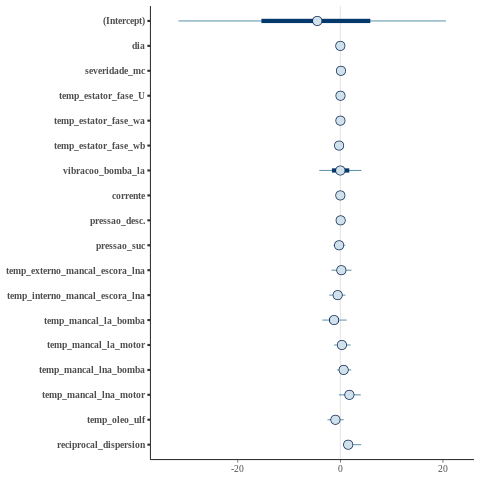

In [72]:
%%R
plot(stan_neg_binomial)

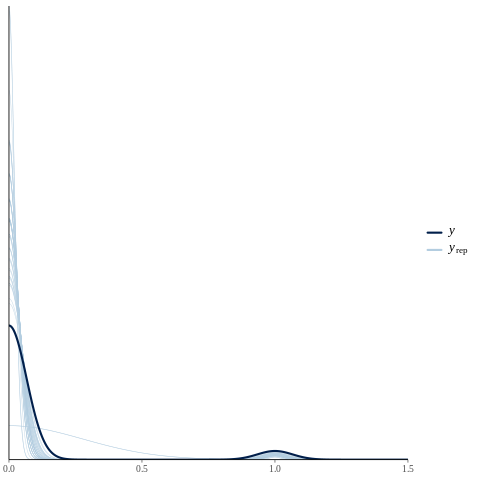

In [73]:
%%R
# Grafico da Posterior Preditive Check da Distribuição Binomial Negativa
# É possivel verificar no grafico abaixo que a função de verossimilhança não se ajusta bem a variavel dependente do modelo
pp_check(stan_neg_binomial, ndraws = 50) + xlim(0, 1.5)

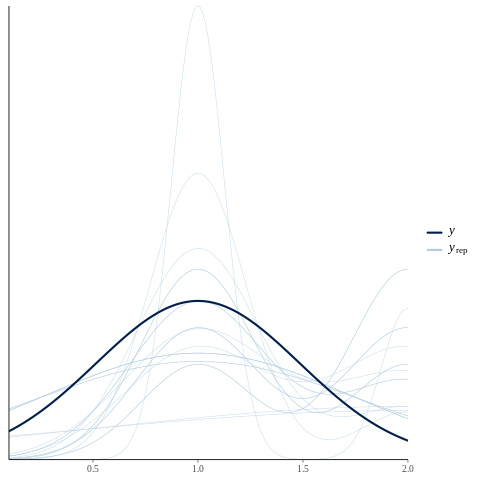

In [74]:
%%R
# Grafico da Posterior Preditive Check da Distribuição Binomial Negativa. faixa entre 0.1 e 2
# É possivel verificar no grafico abaixo que a função de verossimilhança não se ajusta bem a variavel dependente do modelo
pp_check(stan_poisson, ndraws = 50) + xlim(0.1, 2)

In [82]:
%%R
# Abaixo é usada a função exp() para realizar a inverção do logarítmo de (y) para 
# interpretação dos coeficientes do modelo de distribuição Binomial Negativa
coef <- exp(stan_neg_binomial$coefficients)
coef

                   (Intercept)                            dia 
                    0.01100814                     0.98804477 
                 severidade_mc            temp_estator_fase_U 
                    1.11380288                     1.01970377 
          temp_estator_fase_wa           temp_estator_fase_wb 
                    1.00581450                     0.77992425 
             vibracoo_bomba_la                       corrente 
                    0.99504855                     0.99237189 
                 pressao_desc.                    pressao_suc 
                    1.05123201                     0.78082610 
temp_externo_mancal_escora_lna temp_interno_mancal_escora_lna 
                    1.20844738                     0.58658029 
          temp_mancal_la_bomba           temp_mancal_la_motor 
                    0.29299251                     1.34753047 
         temp_mancal_lna_bomba          temp_mancal_lna_motor 
                    1.89170863                     5.77

* (Intercept): a taxa de falhas, 0.01100814 %

* dia: uma media de 0.98804477 % de falhas por dia

* severidade_mc: media de severidade na manutenção aplicada a cada falha 1.11380288 %

* as demais variaves retornaram o valor %(x) em relação a falha

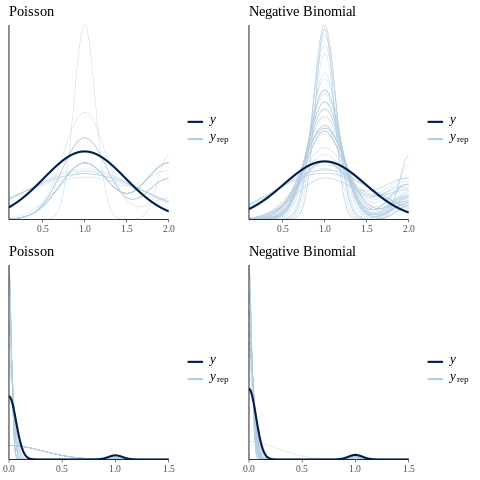

In [83]:
%%R
## Abaixo montamos uma grafoco para comparar os resultados das distribuições de Poissom e a Binomial Negativa.
# No grafico podemos verificar que, visualmente não há muita diferença entre os resultados das distribuições
# Porem usaremos uma função chamada loo() para demostrar com maior precisão a comparação entre as distribuições
test1 <- pp_check(stan_poisson,  ndraws = 50) + xlim(0.1, 2)
test2 <- pp_check(stan_neg_binomial, ndraws = 50) + xlim(0.1, 2)

test3 <- pp_check(stan_poisson, ndraws = 50) + xlim(0, 1.5)
test4 <- pp_check(stan_neg_binomial, ndraws = 50) + xlim(0, 1.5)

t1 <- test1 + ggtitle("Poisson")
t2 <- test2 + ggtitle("Negative Binomial")
t3 <- test3 + ggtitle("Poisson")
t4 <- test4 + ggtitle("Negative Binomial")

ggarrange(t1, t2, t3, t4, ncol = 2, nrow = 2)

In [85]:
%%R
# Abaixo usamos a função loo() para realizar a comparação dos modelos de Poissom e Binomial Negativa
loo_poisson <- loo::loo(stan_poisson)
loo_negbinomial <- loo::loo(stan_neg_binomial)
loop <- loo::loo_compare(loo_poisson, loo_negbinomial)
loop

                  elpd_diff      se_diff       
stan_neg_binomial   0.000000e+00   0.000000e+00
stan_poisson      -5.666553e+179            Inf


* elpd_diff é a diferença da elpdloo para os modelos relativo sempre ao modelo que tem o maior valor de elpdloo. Ou seja, o modelo com maior elpdloo recebe sempre o valor de 0 na comparação.

* se_diff é o erro padrão das diferenças dos modelos comparados ao melhor modelo.

--- Podemos verificar como os resultados que o modelo de Distribuição Binomial Negativa é superior comparado com modelo de Distribuição de Poisson na precisão preditiva

# Referência

* Estimating Generalized Linear Models for Count Data with rstanarm: https://mc-stan.org/rstanarm/articles/count.html

* Poisson regression in Stan: https://rpubs.com/kaz_yos/stan-pois1

* Negative Binomial Distribution: https://rpubs.com/mpfoley73/458738

* Estatística Bayesiana com R e Stan. prof. Dr José Eduardo Storopoli: https://www.youtube.com/watch?v=m_kJwaL2KHQ&list=PLpTXaEnTpmwNwBwwwLTDmCLekoUPtc0cP&index=10

* Estatística Bayesiana prof. Dr José Eduardo Storopoli: https://storopoli.github.io/Estatistica-Bayesiana/8-Regressao_Poisson.html

* Aula Inferência Bayesiana com prof. Gustavo Ferreira: https://www.youtube.com/watch?v=YKZ1euMRsbs&list=PL5nbzsxqG2FPrVmqbLafXqOrE3djThquN

* https://study.sagepub.com/sites/default/files/chapter16.pdf

* Beginners Exercise: Bayesian computation with Stan and Farmer Jöns: https://www.sumsar.net/files/posts/2017-01-15-bayesian-computation-with-stan-and-farmer-jons/stan_exercise.html

* Stan: https://mc-stan.org/

* How to Use the rstanarm Package: https://mc-stan.org/rstanarm/articles/rstanarm.html

* Count Outcome Models with Stan: https://rpubs.com/kaz_yos/stan_count2

* Simulate and fit negative binomial GLMs in Stan: http://rstudio-pubs-static.s3.amazonaws.com/34099_2e35c3966ef548c2918d5b6c2146bfd1.html